#                           <p>           CAPSTONE PROJECT    </p>

##                          Project : Medical Treatment

## Problem statement

A lot has been said during the past several years about how precision medicine and, more concretely, how genetic testing is going to disrupt the way diseases like cancer are treated.

But this is only partially happening due to the huge amount of manual work still required. Once sequenced, a cancer tumor can have thousands of genetic mutations. But the challenge is distinguishing the mutations that contribute to tumor growth (drivers) from the neutral mutations (passengers). 

Currently this interpretation of genetic mutations is being done manually. This is a very time-consuming task where a clinical pathologist has to manually review and classify every single genetic mutation based on evidence from text-based clinical literature.

We need to develop a Machine Learning algorithm that, using this knowledge base as a baseline, automatically classifies genetic variations.

This problem was a competition posted on Kaggle with a award of $15,000. This was launched by  Memorial Sloan Kettering Cancer Center (MSKCC), accepted by NIPS 2017 Competition Track,  because we need your help to take personalized medicine to its full potential.

You can check all details about the competition from following link :
https://www.kaggle.com/c/msk-redefining-cancer-treatment

In order to get the dataset please create a login account to Kaggle and go to this problem statement page(given above) and download 2 dataset

***training_variants.zip*** and ***training_text.zip***

### Analysis of the problem statement

Lets first understand the data set provided and using that dataset we will try to understand the above problem in Machine Learning world. Since, the dataset is huge lets load it using python itself

In [2]:
# Loading all required packages
# If any of it fails, do not panic. Just install it using "pip3 install <package_name>" or by using conda install package_name
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

There are 2 data files provided for solving this problem. I have kept them inside a folder training. So lets load them

In [3]:
# Loading training_variants. Its a comma seperated file
data_variants = pd.read_csv('Datasets/training_variants')
# Loading training_text dataset. This is seperated by ||
data_text = pd.read_csv('Datasets/training_text', sep = "\|\|", engine = "python", names=["ID","TEXT"],skiprows=1)

In [4]:
data_variants.head(3)

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2


<p>
    Let's understand above data. There are 4 fields above: <br>
    <ul>
        <li><b>ID : </b>row id used to link the mutation to the clinical evidence</li>
        <li><b>Gene : </b>the gene where this genetic mutation is located </li>
        <li><b>Variation : </b>the aminoacid change for this mutations </li>
        <li><b>Class :</b> class value 1-9, this genetic mutation has been classified on</li>
    </ul>
    
Keep doing more analysis  on above data.

In [5]:
data_variants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


In [6]:
data_variants.describe()

,ID,Class
count,3321.000000,3321.000000
mean,1660.000000,4.365854
std,958.834449,2.309781
min,0.000000,1.000000
25%,830.000000,2.000000
50%,1660.000000,4.000000
75%,2490.000000,7.000000
max,3320.000000,9.000000


In [7]:
data_variants.shape

(3321, 4)

In [8]:
data_variants.columns

Index(['ID', 'Gene', 'Variation', 'Class'], dtype='object')

Now lets explore about data_text

In [9]:
data_text.head(3)

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...


So above dataset have 2 columns. ID and Text column. We can also observe column ID which is common in both the dataset. Lets keep exploring it.

In [10]:
data_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 2 columns):
ID      3321 non-null int64
TEXT    3316 non-null object
dtypes: int64(1), object(1)
memory usage: 52.0+ KB


In [11]:
data_text.describe()

,ID
count,3321.000000
mean,1660.000000
std,958.834449
min,0.000000
25%,830.000000
50%,1660.000000
75%,2490.000000
max,3320.000000


In [12]:
data_text.columns

Index(['ID', 'TEXT'], dtype='object')

In [13]:
data_text.shape

(3321, 2)

So, in short my datasets looks like this
 * data_variants (ID, Gene, Variations, Class)
 * data_text(ID, text)

Ok, now we understood the dataset. Lets try to understand the same problem from Machine Learning point of view

We want to predict about class of cancer. Now question is what kind of data is present in class column. 

In [14]:
data_variants.Class.unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

This is descrete data so it is ***classification*** problem and since there are multiple descrete output possible so we can call it ***Multi class*** classification problem

***Important note*** : This is medical related problem so correct results are very important. Error can be really costly here so we would like to have result  for each class in terms of Probablity. We might not be much bothered about time taken by ML algorithm as far as it is reasonable. 

We also want our model to be highly interpritable because a medical practitionar want to also give proper reasonining on why ML algorithm is predicting any class. 

We will evaluate our model using Confution matrix and Multi class log-loss

Ok, now we understood the problem statement. Let's work on the solution. 

***Note*** I highly recomend you to attempt the solution on your own first. After that come back and enjoy our solution. 

We have huge amount of text data. So, we need to pre process it. So lets write a function for the same.

In [15]:
stop_words = set(stopwords.words('english'))

In [16]:
def data_text_preprocess(total_text, ind, col):
    # Remove int values from text data as that might not be imp
    if type(total_text) is not int:
        string = ""
        # replacing all special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', str(total_text))
        # replacing multiple spaces with single space
        total_text = re.sub('\s+',' ', str(total_text))
        # bring whole text to same lower-case scale.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from text
            if not word in stop_words:
                string += word + " "
        
        data_text[col][ind] = string

In [17]:
for index,row in data_text.iterrows():
    if type(row['TEXT']) is str:
        data_text_preprocess(row['TEXT'], index, 'TEXT')

Let's merge both the dataset. Remember that ID was common column. So lets use it to merge.

In [18]:
#merging both gene_variations and text data based on ID
result = pd.merge(data_variants, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


It's very important to look for missing values. Else they create problem in final analysis

In [19]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


We can see many rows with missing data. Now the question is what to do with this missing value. One way could be that we can drop these rows having missing values or we can do some imputation in it. Let's go with imputation only. But question is what to impute here :

How about merging Gene and Variation column. Let's do it:

In [20]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

Let's cross check it once again if there is any missing values

In [21]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT


Awesome, so all missing values are gone now.

### Creating Training, Test and Validation data

Before we split the data into taining, test and validation data set. We want to ensure that all spaces in Gene and Variation column to be replaced by _.

In [22]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

Ok, so we can now start our split process in train, test and validation data set.

In [23]:
# Splitting the data into train and test set 
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data now into train validation and cross validation
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [24]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


Let's look at the distribution of data in train, test and validation set.

In [25]:
train_class_distribution = train_df['Class'].value_counts()
test_class_distribution = test_df['Class'].value_counts()
cv_class_distribution = cv_df['Class'].value_counts()

In [26]:
train_class_distribution

7    609
4    439
1    363
2    289
6    176
5    155
3     57
9     24
8     12
Name: Class, dtype: int64

In [27]:
test_class_distribution 

7    191
4    137
1    114
2     91
6     55
5     48
3     18
9      7
8      4
Name: Class, dtype: int64

In [28]:
cv_class_distribution

7    153
4    110
1     91
2     72
6     44
5     39
3     14
9      6
8      3
Name: Class, dtype: int64

So, what does above variable suggest us. This means in my train dataset we have class 1 values with count of 363, class 2 values having count of 289 and so on. It will be better idea to visualise it in graph format.

***Visualizing for train class distrubution***

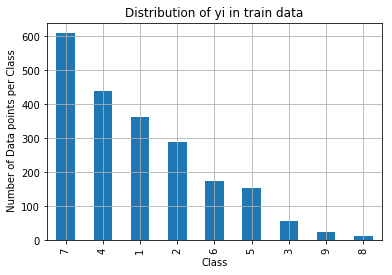

In [29]:
my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel(' Number of Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

Let's look at distribution in form of percentage

In [30]:
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

Number of data points in class 1 : 609 ( 28.672 %)
Number of data points in class 2 : 439 ( 20.669 %)
Number of data points in class 3 : 363 ( 17.09 %)
Number of data points in class 4 : 289 ( 13.606 %)
Number of data points in class 5 : 176 ( 8.286 %)
Number of data points in class 6 : 155 ( 7.298 %)
Number of data points in class 7 : 57 ( 2.684 %)
Number of data points in class 8 : 24 ( 1.13 %)
Number of data points in class 9 : 12 ( 0.565 %)


Let's visualize the same for test set

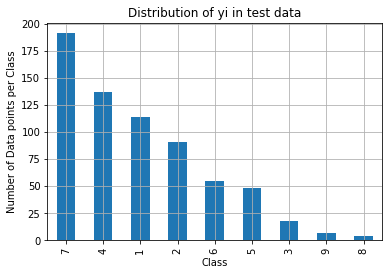

In [31]:
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Number of Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

In [32]:
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

Number of data points in class 1 : 191 ( 28.722 %)
Number of data points in class 2 : 137 ( 20.602 %)
Number of data points in class 3 : 114 ( 17.143 %)
Number of data points in class 4 : 91 ( 13.684 %)
Number of data points in class 5 : 55 ( 8.271 %)
Number of data points in class 6 : 48 ( 7.218 %)
Number of data points in class 7 : 18 ( 2.707 %)
Number of data points in class 8 : 7 ( 1.053 %)
Number of data points in class 9 : 4 ( 0.602 %)


Let's visualize for cross validation set

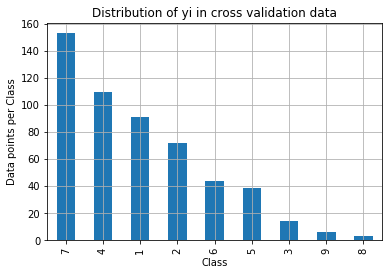

In [33]:
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

In [34]:
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')

Number of data points in class 1 : 153 ( 28.759 %)
Number of data points in class 2 : 110 ( 20.677 %)
Number of data points in class 3 : 91 ( 17.105 %)
Number of data points in class 4 : 72 ( 13.534 %)
Number of data points in class 5 : 44 ( 8.271 %)
Number of data points in class 6 : 39 ( 7.331 %)
Number of data points in class 7 : 14 ( 2.632 %)
Number of data points in class 8 : 6 ( 1.128 %)
Number of data points in class 9 : 3 ( 0.564 %)


Now question is because we need log-loss as final evaluation metrics how do we say that model we are going to build will be good model. For doing this we will build a random model and will evaluate log loss. Our model should return lower log loss value than this. So, what are you waiting for. Always have a bg smile while solving Machine learning problems :). That helps!!

### Building a Random model

Ok, so we need to generate 9 random numbers because we have 9 class such that their sum must be equal to 1 because sum of Probablity of all 9 classes must be equivalent to 1.

In [35]:
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

In [36]:
# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))

Log loss on Cross Validation Data using Random Model 2.5194132017593547


In [37]:
# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))


Log loss on Test Data using Random Model 2.4385771630374866


In [38]:
# Lets get the index of max probablity
predicted_y =np.argmax(test_predicted_y, axis=1)

In [39]:
# Lets see the output. these will be 665 values present in test dataset
predicted_y

array([3, 5, 4, 2, 6, 1, 4, 1, 0, 7, 0, 8, 3, 0, 2, 8, 6, 5, 2, 4, 8, 4,
       6, 0, 4, 8, 8, 6, 2, 6, 1, 8, 4, 5, 1, 8, 5, 7, 8, 2, 4, 3, 6, 8,
       6, 8, 3, 2, 3, 1, 3, 6, 1, 0, 7, 5, 8, 6, 0, 6, 7, 7, 8, 3, 6, 7,
       0, 0, 4, 0, 7, 7, 2, 7, 8, 0, 0, 2, 3, 2, 4, 5, 5, 1, 5, 0, 8, 2,
       7, 8, 7, 8, 5, 3, 1, 2, 5, 1, 2, 3, 6, 2, 1, 6, 0, 7, 7, 1, 3, 5,
       7, 8, 0, 3, 7, 2, 2, 3, 8, 5, 3, 0, 8, 2, 3, 2, 0, 4, 6, 6, 0, 4,
       4, 8, 8, 8, 1, 2, 5, 6, 6, 0, 0, 1, 8, 6, 5, 6, 4, 3, 0, 0, 4, 3,
       3, 2, 7, 0, 2, 7, 5, 1, 4, 0, 6, 4, 4, 1, 2, 1, 8, 7, 5, 7, 8, 4,
       1, 8, 2, 4, 4, 0, 3, 5, 2, 5, 1, 0, 5, 5, 8, 6, 8, 8, 3, 7, 6, 3,
       2, 4, 4, 2, 4, 8, 1, 5, 1, 5, 6, 0, 5, 5, 3, 3, 1, 0, 6, 5, 1, 1,
       3, 5, 4, 8, 2, 0, 1, 3, 1, 6, 4, 6, 4, 6, 4, 2, 3, 0, 0, 5, 2, 2,
       0, 6, 3, 7, 0, 5, 6, 6, 5, 0, 6, 6, 6, 2, 5, 2, 0, 0, 4, 3, 1, 8,
       0, 0, 5, 1, 6, 4, 1, 5, 5, 4, 8, 6, 0, 1, 8, 1, 6, 8, 7, 1, 6, 5,
       7, 1, 8, 2, 5, 3, 8, 8, 2, 8, 7, 7, 8, 7, 8,

So you can see the index value ranging from 0 to 8. So, lets make it as 1 to 9 we will increase this value by 1.

In [40]:
predicted_y = predicted_y + 1

#### Confusion Matrix

In [41]:
C = confusion_matrix(y_test, predicted_y)
C


array([[19, 14, 13, 12, 15, 11, 10,  9, 11],
       [12,  8,  6, 12, 11, 13, 10,  6, 13],
       [ 3,  1,  1,  3,  1,  6,  1,  1,  1],
       [17, 16,  8, 16, 16, 19, 14, 23,  8],
       [11,  4,  4,  3,  6,  3,  4, 10,  3],
       [ 5,  6,  8,  8,  6,  3,  8,  5,  6],
       [20, 22, 20, 15, 25, 16, 28, 21, 24],
       [ 0,  1,  0,  0,  1,  0,  0,  1,  1],
       [ 0,  0,  0,  1,  0,  0,  2,  1,  3]], dtype=int64)

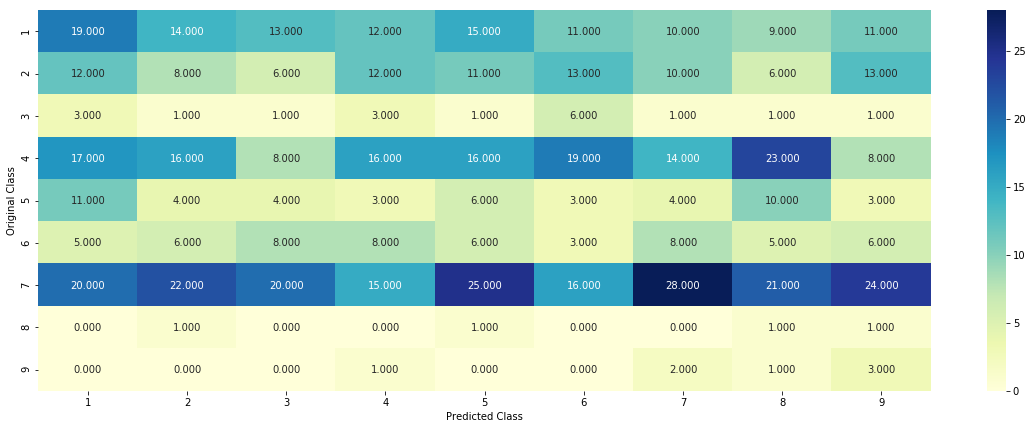

In [42]:
labels = [1,2,3,4,5,6,7,8,9]
plt.figure(figsize=(20,7))
sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

#### Precision matrix

In [43]:
B =(C/C.sum(axis=0))
B

array([[0.2183908 , 0.19444444, 0.21666667, 0.17142857, 0.18518519,
        0.15492958, 0.12987013, 0.11688312, 0.15714286],
       [0.13793103, 0.11111111, 0.1       , 0.17142857, 0.13580247,
        0.18309859, 0.12987013, 0.07792208, 0.18571429],
       [0.03448276, 0.01388889, 0.01666667, 0.04285714, 0.01234568,
        0.08450704, 0.01298701, 0.01298701, 0.01428571],
       [0.1954023 , 0.22222222, 0.13333333, 0.22857143, 0.19753086,
        0.26760563, 0.18181818, 0.2987013 , 0.11428571],
       [0.12643678, 0.05555556, 0.06666667, 0.04285714, 0.07407407,
        0.04225352, 0.05194805, 0.12987013, 0.04285714],
       [0.05747126, 0.08333333, 0.13333333, 0.11428571, 0.07407407,
        0.04225352, 0.1038961 , 0.06493506, 0.08571429],
       [0.22988506, 0.30555556, 0.33333333, 0.21428571, 0.30864198,
        0.22535211, 0.36363636, 0.27272727, 0.34285714],
       [0.        , 0.01388889, 0.        , 0.        , 0.01234568,
        0.        , 0.        , 0.01298701, 0.01428571],


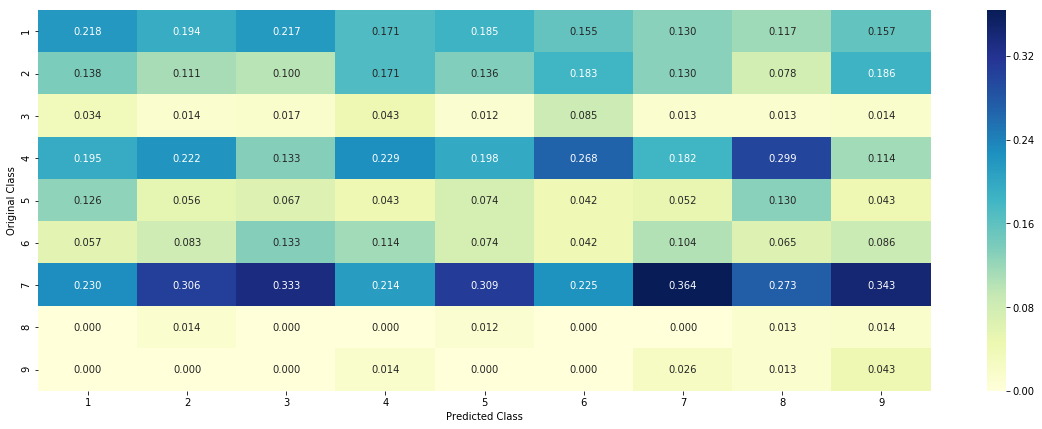

In [44]:
plt.figure(figsize=(20,7))
sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

#### Recall matrix

In [45]:
A =(((C.T)/(C.sum(axis=1))).T)
A

array([[0.16666667, 0.12280702, 0.11403509, 0.10526316, 0.13157895,
        0.09649123, 0.0877193 , 0.07894737, 0.09649123],
       [0.13186813, 0.08791209, 0.06593407, 0.13186813, 0.12087912,
        0.14285714, 0.10989011, 0.06593407, 0.14285714],
       [0.16666667, 0.05555556, 0.05555556, 0.16666667, 0.05555556,
        0.33333333, 0.05555556, 0.05555556, 0.05555556],
       [0.12408759, 0.11678832, 0.05839416, 0.11678832, 0.11678832,
        0.13868613, 0.10218978, 0.16788321, 0.05839416],
       [0.22916667, 0.08333333, 0.08333333, 0.0625    , 0.125     ,
        0.0625    , 0.08333333, 0.20833333, 0.0625    ],
       [0.09090909, 0.10909091, 0.14545455, 0.14545455, 0.10909091,
        0.05454545, 0.14545455, 0.09090909, 0.10909091],
       [0.10471204, 0.11518325, 0.10471204, 0.07853403, 0.13089005,
        0.08376963, 0.14659686, 0.10994764, 0.12565445],
       [0.        , 0.25      , 0.        , 0.        , 0.25      ,
        0.        , 0.        , 0.25      , 0.25      ],


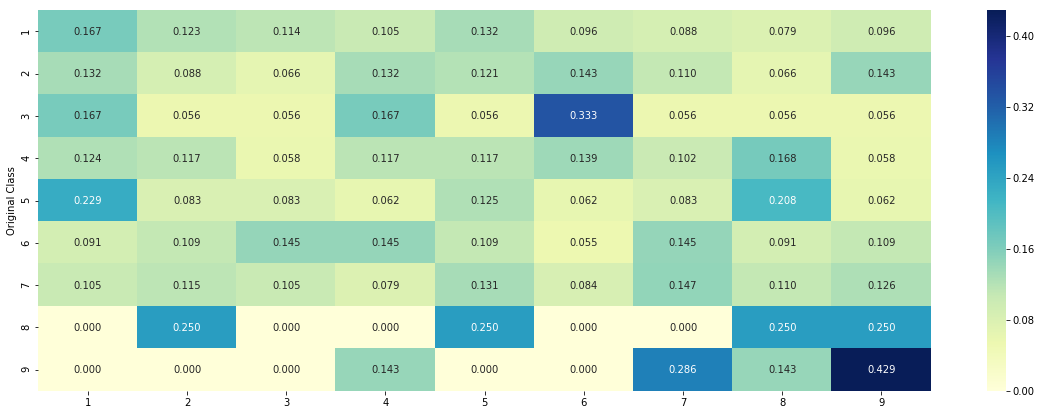

In [46]:
plt.figure(figsize=(20,7))
sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.ylabel('Original Class')
plt.show()

### Evaluating Gene Column

Now we will look at each independent column to make sure its relavent for my target variable but the question is, how? Let's understand with our first column Gene which is categorial in nature.

So, lets explore column ***Gene*** and lets look at its distribution. 

In [47]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 236
BRCA1     170
TP53      105
EGFR       93
BRCA2      78
PTEN       72
KIT        64
BRAF       60
ALK        44
PDGFRA     41
ERBB2      39
Name: Gene, dtype: int64


Lets see the number of unique values present in gene

In [48]:
unique_genes.shape[0]

236

Lets look at the comulative distribution of unique Genes values

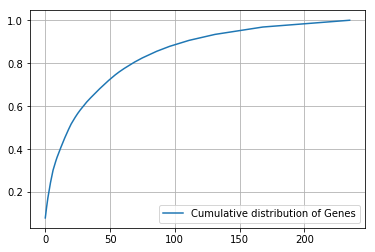

In [49]:
s = sum(unique_genes.values);
h = unique_genes.values/s;
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

So, now we need to convert these categorical variable to appropirate format which my machine learning algorithm will be able to take as an input.

So we have 2 techniques to deal with it. 

<ol><li>
     ***One-hot encoding***</li>
    <li>***Response Encoding***(Mean imputation)</li>
</ol>

Let's use both of them to see which one work the best. So lets start encoding using one hot encoder

In [50]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

Let's check the number of column generated after one hot encoding. One hot encoding will always return higher number of column.

In [51]:
train_gene_feature_onehotCoding.shape

(2124, 235)

In [52]:
#column names after one-hot encoding for Gene column
gene_vectorizer.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1a',
 'arid1b',
 'arid2',
 'asxl1',
 'asxl2',
 'atm',
 'atr',
 'atrx',
 'aurka',
 'aurkb',
 'axin1',
 'b2m',
 'bap1',
 'bard1',
 'bcl10',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd2',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdk8',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cdkn2c',
 'cebpa',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctla4',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'egfr',
 'elf3',
 'ep300',
 'epas1',
 'epcam',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc4',
 'erg',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fam58a',
 'fanca',
 'fancc',
 'fat1',
 'fbxw7',
 'fgf19',
 'fgf3',
 'fgf4',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt1',
 'flt3',
 'foxa1',
 'foxl2',
 'foxo1',
 'foxp1',
 'fubp1',
 'gata3',
 'gli1',
 'gna11',
 'gnas',
 'h3f3a',
 'hla',
 'hnf1a',
 'hras

Now, lets also create Response encoding columns for Gene column

In [53]:
# code for response coding with Laplace smoothing.
# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['train_df', 'test_df', 'cv_df']
# algorithm
# ----------
# Consider all unique values and the number of occurances of given feature in train data dataframe
# build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+90*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it
# for a value of feature in df:
# if it is in train data:
# we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# if it is not there is train:
# we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# ----------------------

# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    # value_count: it contains a dict like
    # print(train_df['Gene'].value_counts())
    # output:
    #        {BRCA1      174
    #         TP53       106
    #         EGFR        86
    #         BRCA2       75
    #         PTEN        69
    #         KIT         61
    #         BRAF        60
    #         ERBB2       47
    #         PDGFRA      46
    #         ...}
    # print(train_df['Variation'].value_counts())
    # output:
    # {
    # Truncating_Mutations                     63
    # Deletion                                 43
    # Amplification                            43
    # Fusions                                  22
    # Overexpression                            3
    # E17K                                      3
    # Q61L                                      3
    # S222D                                     2
    # P130S                                     2
    # ...
    # }
    value_count = train_df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # 2486  2486  BRCA1                S1841R      1   
            # 2614  2614  BRCA1                   M1R      1   
            # 2432  2432  BRCA1                L1657P      1   
            # 2567  2567  BRCA1                T1685A      1   
            # 2583  2583  BRCA1                E1660G      1   
            # 2634  2634  BRCA1                W1718L      1   
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    # print(gv_dict)
    #     {'BRCA1': [0.20075757575757575, 0.03787878787878788, 0.068181818181818177, 0.13636363636363635, 0.25, 0.19318181818181818, 0.03787878787878788, 0.03787878787878788, 0.03787878787878788], 
    #      'TP53': [0.32142857142857145, 0.061224489795918366, 0.061224489795918366, 0.27040816326530615, 0.061224489795918366, 0.066326530612244902, 0.051020408163265307, 0.051020408163265307, 0.056122448979591837], 
    #      'EGFR': [0.056818181818181816, 0.21590909090909091, 0.0625, 0.068181818181818177, 0.068181818181818177, 0.0625, 0.34659090909090912, 0.0625, 0.056818181818181816], 
    #      'BRCA2': [0.13333333333333333, 0.060606060606060608, 0.060606060606060608, 0.078787878787878782, 0.1393939393939394, 0.34545454545454546, 0.060606060606060608, 0.060606060606060608, 0.060606060606060608], 
    #      'PTEN': [0.069182389937106917, 0.062893081761006289, 0.069182389937106917, 0.46540880503144655, 0.075471698113207544, 0.062893081761006289, 0.069182389937106917, 0.062893081761006289, 0.062893081761006289], 
    #      'KIT': [0.066225165562913912, 0.25165562913907286, 0.072847682119205295, 0.072847682119205295, 0.066225165562913912, 0.066225165562913912, 0.27152317880794702, 0.066225165562913912, 0.066225165562913912], 
    #      'BRAF': [0.066666666666666666, 0.17999999999999999, 0.073333333333333334, 0.073333333333333334, 0.093333333333333338, 0.080000000000000002, 0.29999999999999999, 0.066666666666666666, 0.066666666666666666],
    #      ...
    #     }
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

In [54]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

Let's look at columns after applying response encoding. We must be having 9 columns for Gene column after response encoding.

In [55]:
train_gene_feature_responseCoding.shape

(2124, 9)

Now, question is how good is Gene column feature to predict my 9 classes. One idea could be that we will build model having only gene column with one hot encoder with simple model like Logistic regression. If log loss with only one column Gene comes out to be better than random model, than this feature is important.

In [56]:
# We need a hyperparemeter for SGD classifier.
alpha = [10** x for x in range(-5, 1)]

In [57]:
# We will be using SGD classifier
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# We will also be using Calibrated Classifier to get the result into probablity format t be used for log loss
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))


For values of alpha =  1e-05 The log loss is: 1.3920458896350856
For values of alpha =  0.0001 The log loss is: 1.2452552018736136
For values of alpha =  0.001 The log loss is: 1.242287026837259
For values of alpha =  0.01 The log loss is: 1.347278200953364
For values of alpha =  0.1 The log loss is: 1.4393783518235304
For values of alpha =  1 The log loss is: 1.4778674196538455


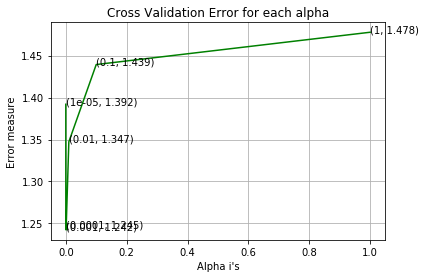

In [58]:
# Lets plot the same to check the best Alpha value
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [59]:
# Lets use best alpha value as we can see from above graph and compute log loss
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  0.001 The train log loss is: 1.094286687193049
For values of best alpha =  0.001 The cross validation log loss is: 1.242287026837259
For values of best alpha =  0.001 The test log loss is: 1.2060831559596157


Now lets check how many values are overlapping between train, test or between CV and train

In [60]:
test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

In [61]:
print('1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

1. In test data 641 out of 665 : 96.39097744360903
2. In cross validation data 517 out of  532 : 97.18045112781954


### Evaluating Variation column

Variation is also a categorical variable so we have to deal in same way like we have done for ***Gene*** column. We will again get the one hot encoder and response enoding variable for variation column.

In [62]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1921
Truncating_Mutations    66
Deletion                53
Amplification           48
Fusions                 16
Overexpression           4
G12V                     4
Q61R                     3
G13D                     2
Q22K                     2
G35R                     2
Name: Variation, dtype: int64


Lets look at the comulative distribution of unique ***variation*** values

[0.03107345 0.05602637 0.07862524 ... 0.99905838 0.99952919 1.        ]


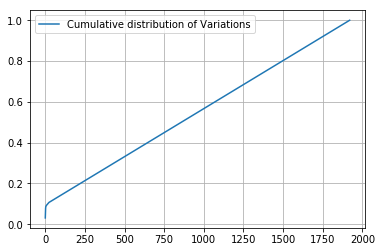

In [63]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

Lets convert the variation column using one hot encoder column

In [64]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

Lets look at shape of one hot encoder column for variation

In [65]:
train_variation_feature_onehotCoding.shape

(2124, 1950)

Lets do the same for variation column and generate response encoding for the same.

In [66]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

Lets look at the shape of this response encoding result

In [67]:
train_variation_feature_responseCoding.shape

(2124, 9)

Lets again build the model with only column name of ***variation*** column

In [68]:
# We need a hyperparemeter for SGD classifier.
alpha = [10 ** x for x in range(-5, 1)]

In [69]:
# We will be using SGD classifier
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# We will also be using Calibrated Classifier to get the result into probablity format t be used for log loss
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.7290523860050546
For values of alpha =  0.0001 The log loss is: 1.7235970969172536
For values of alpha =  0.001 The log loss is: 1.7181742868335728
For values of alpha =  0.01 The log loss is: 1.7266198915848447
For values of alpha =  0.1 The log loss is: 1.7431001234702597
For values of alpha =  1 The log loss is: 1.7445150635377562


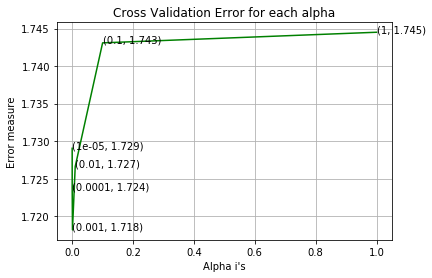

In [70]:
# Lets plot the same to check the best Alpha value
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [71]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 1.0018679026165498
For values of best alpha =  0.001 The cross validation log loss is: 1.7181742868335728
For values of best alpha =  0.001 The test log loss is: 1.727403032017904


In [72]:
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]

In [73]:
print('1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

1. In test data 65 out of 665 : 9.774436090225564
2. In cross validation data 53 out of  532 : 9.962406015037594


### Evaluating Text column

In [74]:
# cls_text is a data frame
# for every row in data fram consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [75]:
import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [76]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 53882


In [77]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [78]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [79]:
# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [80]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [81]:
#https://stackoverflow.com/a/2258273/4084039
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [82]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({3: 5922, 4: 3696, 5: 2813, 6: 2541, 8: 1938, 7: 1894, 9: 1654, 10: 1649, 11: 1488, 12: 1249, 13: 1015, 15: 933, 14: 860, 16: 804, 18: 797, 21: 616, 20: 613, 17: 583, 19: 510, 22: 478, 24: 460, 40: 430, 25: 430, 30: 369, 23: 363, 27: 352, 28: 339, 32: 334, 26: 334, 29: 311, 36: 295, 33: 279, 31: 272, 52: 259, 35: 257, 42: 245, 34: 241, 37: 212, 39: 204, 38: 190, 48: 184, 41: 181, 43: 169, 45: 167, 50: 162, 46: 159, 44: 159, 54: 155, 53: 155, 66: 151, 56: 144, 51: 143, 60: 141, 55: 139, 57: 135, 47: 133, 58: 132, 49: 131, 63: 117, 59: 116, 62: 113, 68: 108, 72: 106, 64: 106, 77: 105, 61: 102, 84: 99, 80: 94, 67: 94, 75: 90, 73: 87, 69: 87, 83: 83, 65: 82, 78: 81, 71: 81, 74: 79, 82: 77, 81: 76, 79: 75, 93: 73, 90: 73, 70: 71, 89: 70, 88: 69, 91: 68, 104: 67, 86: 66, 76: 65, 126: 60, 85: 60, 110: 59, 92: 58, 87: 58, 114: 56, 103: 56, 100: 56, 96: 56, 106: 55, 99: 55, 97: 54, 105: 51, 95: 51, 120: 50, 116: 48, 101: 48, 122: 47, 113: 47, 108: 47, 94: 46, 129: 45, 111: 45, 98: 45, 1

Lets build the model with only ***text*** column

In [83]:
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))


For values of alpha =  1e-05 The log loss is: 1.365950034588302
For values of alpha =  0.0001 The log loss is: 1.332142994524572
For values of alpha =  0.001 The log loss is: 1.1928742157503085
For values of alpha =  0.01 The log loss is: 1.265635200879001
For values of alpha =  0.1 The log loss is: 1.4792657699172163
For values of alpha =  1 The log loss is: 1.7238222145125175


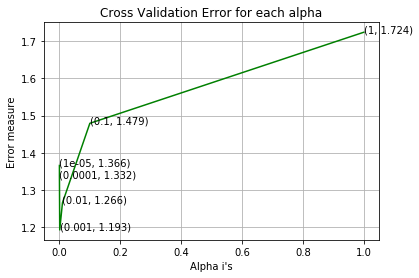

In [84]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [85]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  0.001 The train log loss is: 0.7523727003607393
For values of best alpha =  0.001 The cross validation log loss is: 1.1928742157503085
For values of best alpha =  0.001 The test log loss is: 1.160968511528587


Lets check the overlap of text data

In [86]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [87]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

95.147 % of word of test data appeared in train data
97.505 % of word of Cross Validation appeared in train data


So, all 3 columns are going to be important.

### Data prepration for Machine Learning models

Lets create few functions which we will be using later

In [88]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [89]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0)) 
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [90]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

### Combining all 3 features together

In [91]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))


In [92]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 56067)
(number of data points * number of features) in test data =  (665, 56067)
(number of data points * number of features) in cross validation data = (532, 56067)


In [93]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


## Building Machine Learning model

Lets start the first model which is most suitable when we have lot of text column data. So, we will start with Naive Bayes.

## Naive Bayes

In [94]:
# http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
alpha = [10**i for i in range(-10,10)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

for alpha = 1e-10
Log Loss : 1.321324166006515
for alpha = 1e-09
Log Loss : 1.323005742456674
for alpha = 1e-08
Log Loss : 1.3253476492977958
for alpha = 1e-07
Log Loss : 1.3215493139835697
for alpha = 1e-06
Log Loss : 1.3215136069673457
for alpha = 1e-05
Log Loss : 1.3196585617862586
for alpha = 0.0001
Log Loss : 1.3202406390389334
for alpha = 0.001
Log Loss : 1.320126271812809
for alpha = 0.01
Log Loss : 1.3144312527122453
for alpha = 0.1
Log Loss : 1.3051053979773677
for alpha = 1
Log Loss : 1.2861394834647761
for alpha = 10
Log Loss : 1.3770299178988488
for alpha = 100
Log Loss : 1.3396282036219078
for alpha = 1000
Log Loss : 1.2925065319274742
for alpha = 10000
Log Loss : 1.2822214040814435
for alpha = 100000
Log Loss : 1.2817296177684596
for alpha = 1000000
Log Loss : 1.3064587642994208
for alpha = 10000000
Log Loss : 1.3295980389819286
for alpha = 100000000
Log Loss : 1.6583750274707896
for alpha = 1000000000
Log Loss : 1.8302599806298


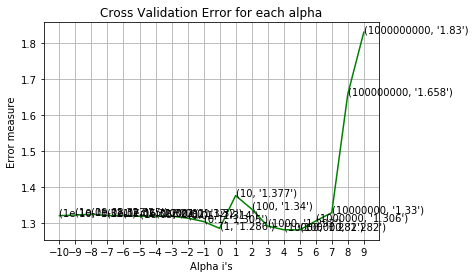

In [95]:
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [96]:
best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  100000 The train log loss is: 1.0389679122569202
For values of best alpha =  100000 The cross validation log loss is: 1.2817296177684596
For values of best alpha =  100000 The test log loss is: 1.275643992670591


In [97]:
import gc
gc.collect()

4628

Now we make a better guess for hyperparameters.

In [98]:
# http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
alpha = [10000*i for i in range(1,100)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

for alpha = 10000
Log Loss : 1.2822214040814435
for alpha = 20000
Log Loss : 1.2813854407469476
for alpha = 30000
Log Loss : 1.2812244757266873
for alpha = 40000
Log Loss : 1.2796275956879661
for alpha = 50000
Log Loss : 1.2795770582601542
for alpha = 60000
Log Loss : 1.279543365481051
for alpha = 70000
Log Loss : 1.2817728440528333
for alpha = 80000
Log Loss : 1.2817548388029882
for alpha = 90000
Log Loss : 1.281740724901015
for alpha = 100000
Log Loss : 1.2817296177684596
for alpha = 110000
Log Loss : 1.2817204519682266
for alpha = 120000
Log Loss : 1.2817127212357007
for alpha = 130000
Log Loss : 1.2817063839915324
for alpha = 140000
Log Loss : 1.2817008047064034
for alpha = 150000
Log Loss : 1.281695995854672
for alpha = 160000
Log Loss : 1.281691810261576
for alpha = 170000
Log Loss : 1.2816880216363296
for alpha = 180000
Log Loss : 1.2816847028723806
for alpha = 190000
Log Loss : 1.2816818352142691
for alpha = 200000
Log Loss : 1.2816791991015946
for alpha = 210000
Log Loss : 1.2

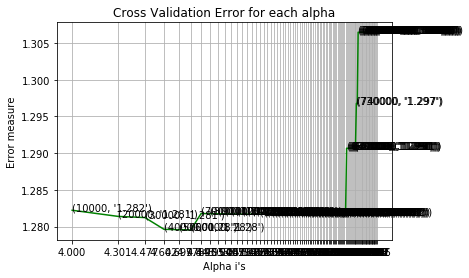

In [99]:
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [100]:
best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  60000 The train log loss is: 1.0366338395267003
For values of best alpha =  60000 The cross validation log loss is: 1.279543365481051
For values of best alpha =  60000 The test log loss is: 1.2768883528978414


In [101]:
# http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
alpha = [(60000+(100*i)) for i in range(1,100)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

for alpha = 60100
Log Loss : 1.2795430824847551
for alpha = 60200
Log Loss : 1.2795428035726815
for alpha = 60300
Log Loss : 1.279542525337414
for alpha = 60400
Log Loss : 1.2795422480904242
for alpha = 60500
Log Loss : 1.2795419710980211
for alpha = 60600
Log Loss : 1.2795416959284889
for alpha = 60700
Log Loss : 1.2795414213082268
for alpha = 60800
Log Loss : 1.2795411475430334
for alpha = 60900
Log Loss : 1.2795408748743657
for alpha = 61000
Log Loss : 1.2795406029564664
for alpha = 61100
Log Loss : 1.2795403319251588
for alpha = 61200
Log Loss : 1.2795400585859191
for alpha = 61300
Log Loss : 1.2795397924608451
for alpha = 61400
Log Loss : 1.2795395241363094
for alpha = 61500
Log Loss : 1.2795392567706414
for alpha = 61600
Log Loss : 1.2795389849049188
for alpha = 61700
Log Loss : 1.279538716904311
for alpha = 61800
Log Loss : 1.2795384520480328
for alpha = 61900
Log Loss : 1.2795381880529089
for alpha = 62000
Log Loss : 1.2795379245983565
for alpha = 62100
Log Loss : 1.27953766223

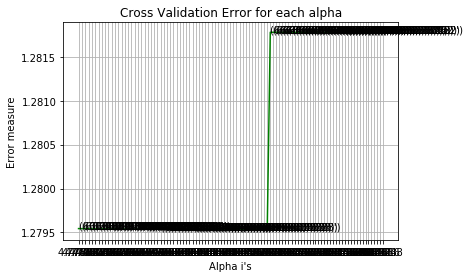

In [102]:
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [103]:
best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  66000 The train log loss is: 1.0366273358708535
For values of best alpha =  66000 The cross validation log loss is: 1.2795279715834385
For values of best alpha =  66000 The test log loss is: 1.276873608252134


Testing our Naive Bayes model with best found value of alpha on testing data

Log Loss : 1.2795279715834385
Number of missclassified point : 0.42857142857142855
-------------------- Confusion matrix --------------------


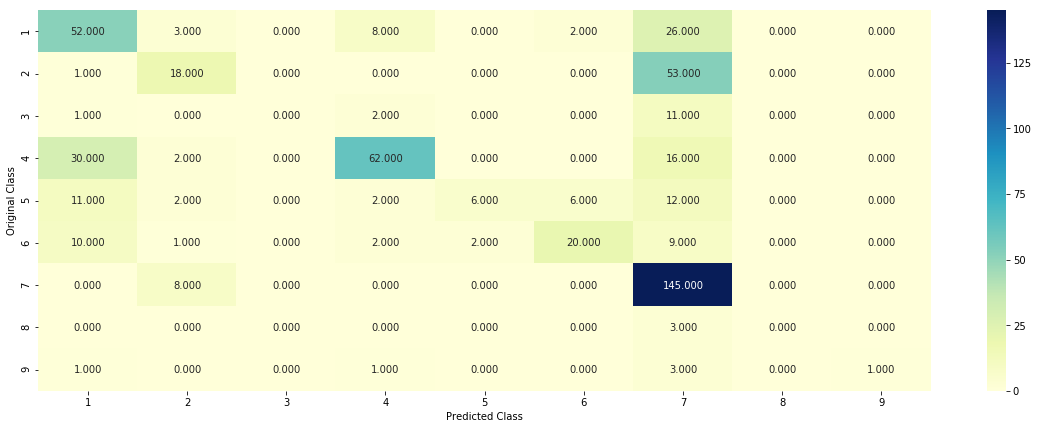

-------------------- Precision matrix (Columm Sum=1) --------------------


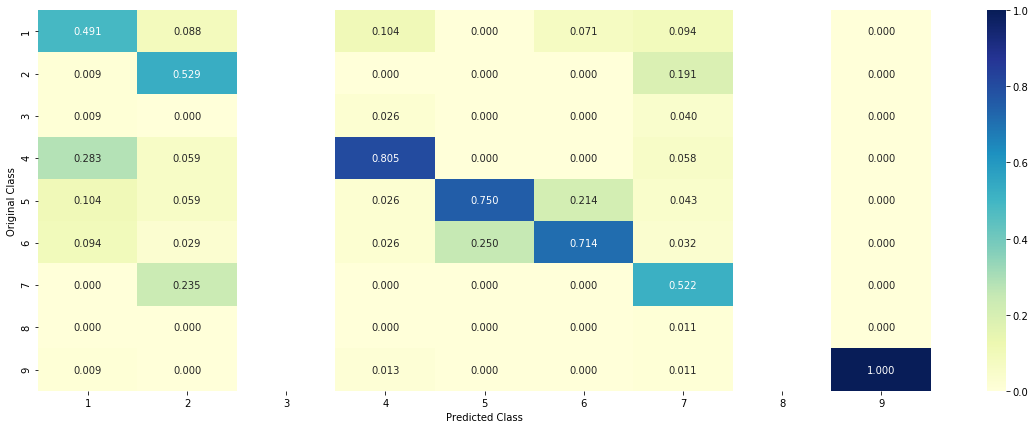

-------------------- Recall matrix (Row sum=1) --------------------


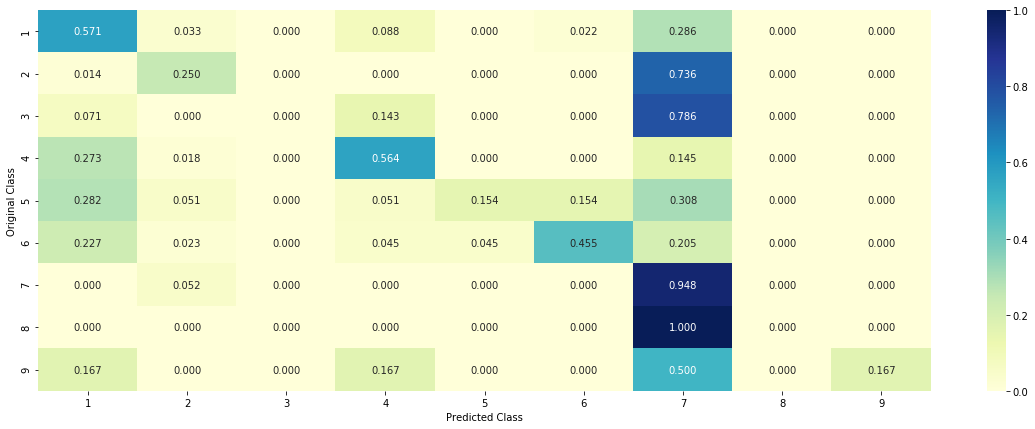

In [104]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

### Interpretability of our model

In [105]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.1068 0.3237 0.0277 0.1377 0.0628 0.0671 0.2595 0.0073 0.0074]]
Actual Class : 2
--------------------------------------------------
16 Text feature [clinical] present in test data point [True]
17 Text feature [identified] present in test data point [True]
18 Text feature [achieved] present in test data point [True]
19 Text feature [patient] present in test data point [True]
20 Text feature [detection] present in test data point [True]
26 Text feature [molecular] present in test data point [True]
27 Text feature [sequencing] present in test data point [True]
28 Text feature [novel] present in test data point [True]
29 Text feature [including] present in test data point [True]
30 Text feature [new] present in test data point [True]
32 Text feature [mutations] present in test data point [True]
33 Text feature [15] present in test data point [True]
35 Text feature [90] present in test data point [True]
36 Text feature [therapy] present 

Lets look at one more point

In [106]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1706 0.205  0.0391 0.1449 0.0727 0.0831 0.2636 0.0088 0.0122]]
Actual Class : 2
--------------------------------------------------
22 Text feature [well] present in test data point [True]
23 Text feature [presence] present in test data point [True]
24 Text feature [recently] present in test data point [True]
25 Text feature [cell] present in test data point [True]
26 Text feature [inhibitor] present in test data point [True]
27 Text feature [independent] present in test data point [True]
28 Text feature [contrast] present in test data point [True]
29 Text feature [potential] present in test data point [True]
30 Text feature [cells] present in test data point [True]
31 Text feature [activation] present in test data point [True]
32 Text feature [also] present in test data point [True]
33 Text feature [shown] present in test data point [True]
38 Text feature [factor] present in test data point [True]
40 Text feature [however] present 

So Naive Bayes not performing very badly but lets look at other models

## K Nearest Neighbour Classification

In [117]:
alpha = [(i) for i in range(1,150)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs))

for alpha = 1
Log Loss : 1.3812380152121884
for alpha = 2
Log Loss : 1.2543461267824123
for alpha = 3
Log Loss : 1.177621246239945
for alpha = 4
Log Loss : 1.128577261826944
for alpha = 5
Log Loss : 1.109951717317411
for alpha = 6
Log Loss : 1.0932449027213034
for alpha = 7
Log Loss : 1.0860896414744943
for alpha = 8
Log Loss : 1.078098504082661
for alpha = 9
Log Loss : 1.0774552777258948
for alpha = 10
Log Loss : 1.077940737415485
for alpha = 11
Log Loss : 1.0787951888758354
for alpha = 12
Log Loss : 1.0733112026790756
for alpha = 13
Log Loss : 1.0706479552955437
for alpha = 14
Log Loss : 1.0747142214909509
for alpha = 15
Log Loss : 1.0756302739199994
for alpha = 16
Log Loss : 1.074160458205913
for alpha = 17
Log Loss : 1.075927207426585
for alpha = 18
Log Loss : 1.0761016760700988
for alpha = 19
Log Loss : 1.075616902244541
for alpha = 20
Log Loss : 1.0758124957749573
for alpha = 21
Log Loss : 1.0744737161529332
for alpha = 22
Log Loss : 1.0727184881142768
for alpha = 23
Log Loss : 1

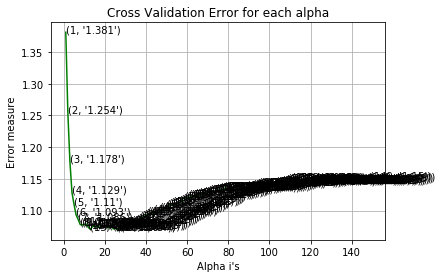

In [118]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [119]:
best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  28 The train log loss is: 0.7994170836029928
For values of best alpha =  28 The cross validation log loss is: 1.0696210699292021
For values of best alpha =  28 The test log loss is: 1.0994370950179573


Let's test it on testing dataset with our best alpha value

Log loss : 1.0696210699292021
Number of mis-classified points : 0.37406015037593987
-------------------- Confusion matrix --------------------


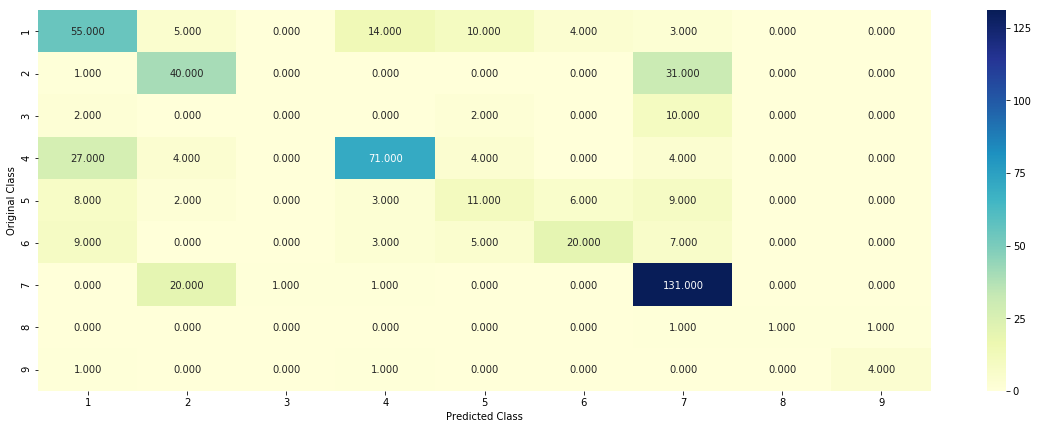

-------------------- Precision matrix (Columm Sum=1) --------------------


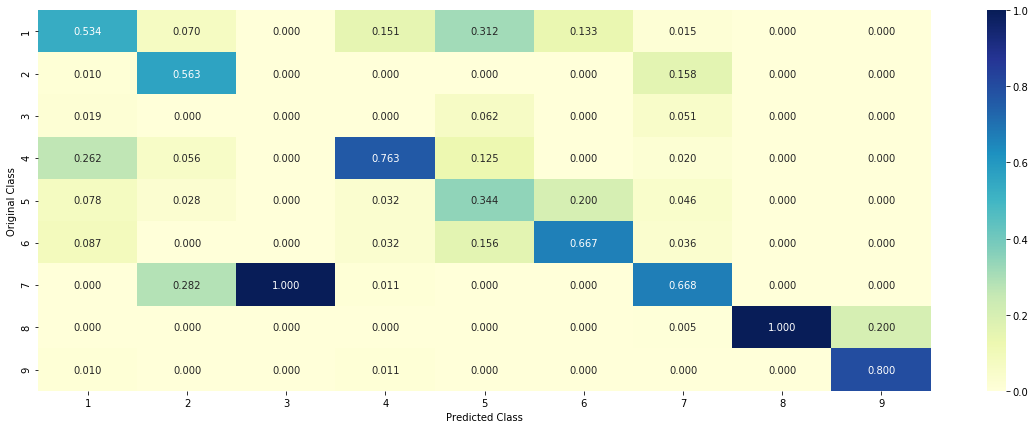

-------------------- Recall matrix (Row sum=1) --------------------


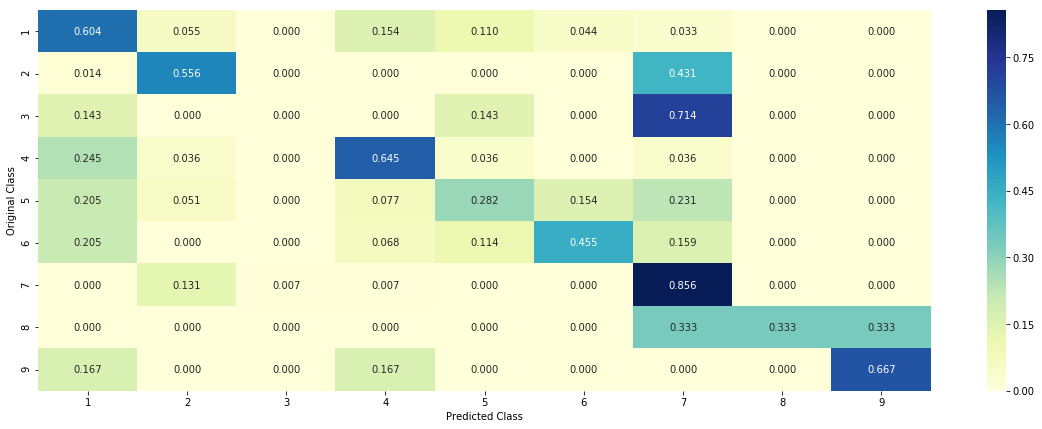

In [120]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

In [121]:
# Lets look at few test points
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 1
Actual Class : 2
The  28  nearest neighbours of the test points belongs to classes [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 7 2 2 7 2 2 2 2]
Fequency of nearest points : Counter({2: 26, 7: 2})


In [122]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 100

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 2
Actual Class : 2
the k value for knn is 28 and the nearest neighbours of the test points belongs to classes [1 2 1 7 1 2 6 8 4 8 8 4 1 1 7 6 4 5 1 5 4 2 2 2 1 9 9 2]
Fequency of nearest points : Counter({1: 7, 2: 6, 4: 4, 8: 3, 7: 2, 6: 2, 5: 2, 9: 2})


## Logistic Regression

### Balancing all classes

In [129]:
alpha = [(y*(10**x)) for y in range(1,10) for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


for alpha = 1e-06
Log Loss : 1.4103220647074444
for alpha = 1e-05
Log Loss : 1.4000825238292691
for alpha = 0.0001
Log Loss : 1.3351645758265378
for alpha = 0.001
Log Loss : 1.1379919802414586
for alpha = 0.01
Log Loss : 1.1708174726618732
for alpha = 0.1
Log Loss : 1.4816271102121774
for alpha = 1
Log Loss : 1.689887922078703
for alpha = 10
Log Loss : 1.7148501507846408
for alpha = 100
Log Loss : 1.7174895750250898
for alpha = 2e-06
Log Loss : 1.434245869793646
for alpha = 2e-05
Log Loss : 1.4258551610491634
for alpha = 0.0002
Log Loss : 1.24761958698267
for alpha = 0.002
Log Loss : 1.1285939757496446
for alpha = 0.02
Log Loss : 1.2163344304553312
for alpha = 0.2
Log Loss : 1.5882594545438238
for alpha = 2
Log Loss : 1.7036277205655002
for alpha = 20
Log Loss : 1.7162916501592738
for alpha = 200
Log Loss : 1.717634008089073
for alpha = 3e-06
Log Loss : 1.4426552157382524
for alpha = 3.0000000000000004e-05
Log Loss : 1.4062602719611315
for alpha = 0.00030000000000000003
Log Loss : 1.20

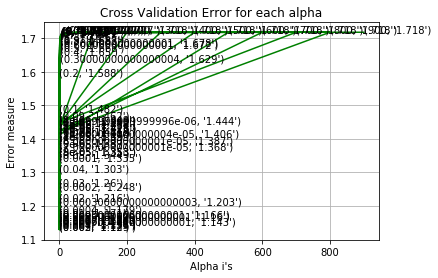

In [130]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [131]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.002 The train log loss is: 0.6266820043476671
For values of best alpha =  0.002 The cross validation log loss is: 1.1285939757496446
For values of best alpha =  0.002 The test log loss is: 1.1116992720744565


Lets test it on testing data using best alpha value

Log loss : 1.1285939757496446
Number of mis-classified points : 0.37781954887218044
-------------------- Confusion matrix --------------------


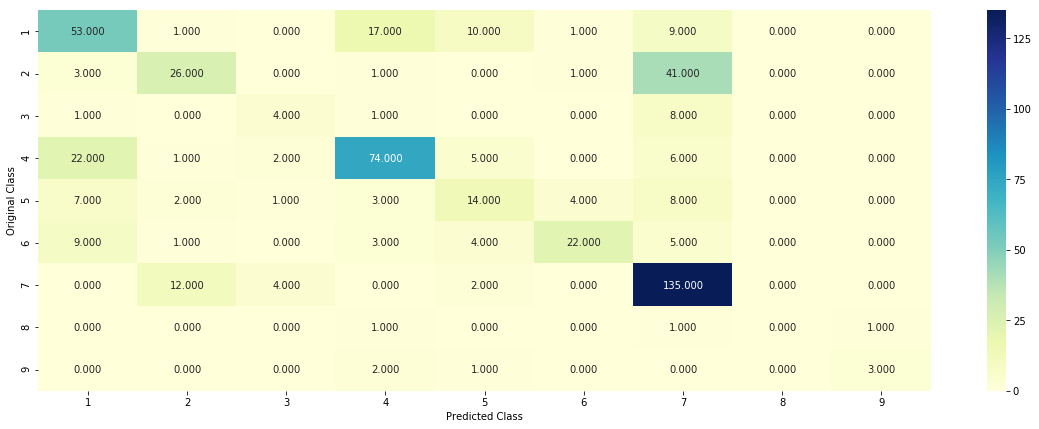

-------------------- Precision matrix (Columm Sum=1) --------------------


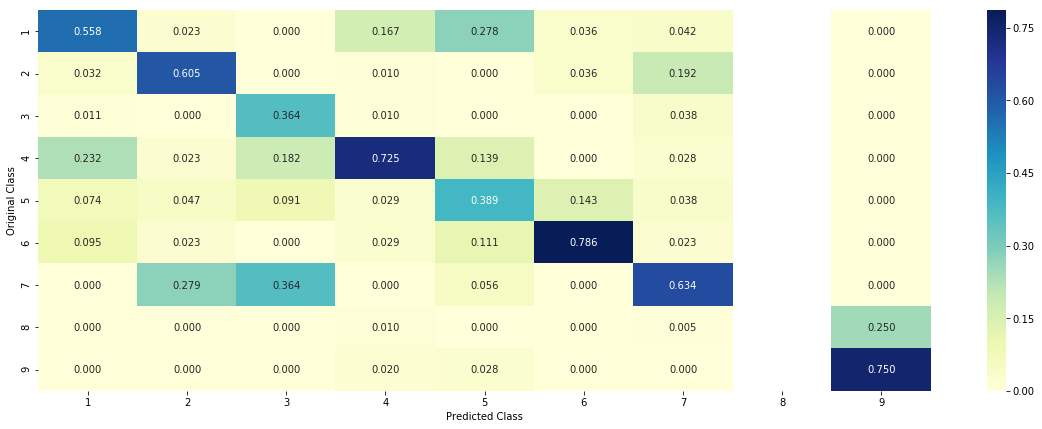

-------------------- Recall matrix (Row sum=1) --------------------


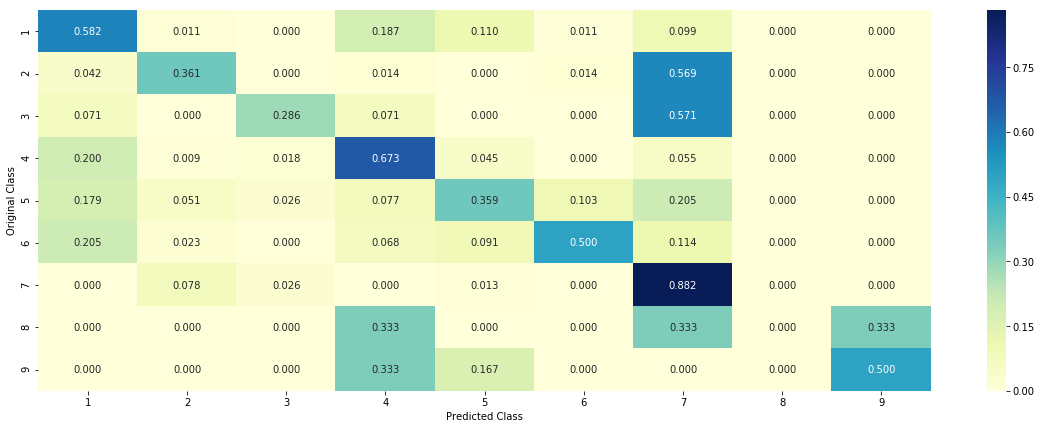

In [132]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

### Feature importance

In [133]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

testing query point and doing interpretability

In [134]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.1214 0.3791 0.0198 0.139  0.0644 0.067  0.1942 0.0069 0.0082]]
Actual Class : 2
--------------------------------------------------
77 Text feature [e255k] present in test data point [True]
104 Text feature [ccyr] present in test data point [True]
133 Text feature [t315i] present in test data point [True]
273 Text feature [ai] present in test data point [True]
278 Text feature [l387m] present in test data point [True]
Out of the top  500  features  5 are present in query point


In [135]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.223  0.1621 0.0222 0.1457 0.0587 0.079  0.2964 0.0055 0.0075]]
Actual Class : 2
--------------------------------------------------
34 Text feature [receptors] present in test data point [True]
52 Text feature [overlapped] present in test data point [True]
57 Text feature [receptor] present in test data point [True]
131 Text feature [activation] present in test data point [True]
143 Text feature [filters] present in test data point [True]
174 Text feature [nf] present in test data point [True]
369 Text feature [inhibitor] present in test data point [True]
471 Text feature [necessity] present in test data point [True]
475 Text feature [transduction] present in test data point [True]
Out of the top  500  features  9 are present in query point


### Without class balancing

In [136]:
alpha = [((10**x)*y) for x in range(-6, 2) for y in range(1, 10)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


for alpha = 1e-06
Log Loss : 1.3812166371775947
for alpha = 2e-06
Log Loss : 1.3774054390634236
for alpha = 3e-06
Log Loss : 1.3708583805219712
for alpha = 4e-06
Log Loss : 1.3731166418469543
for alpha = 4.9999999999999996e-06
Log Loss : 1.3837556154251365
for alpha = 6e-06
Log Loss : 1.3688130270107988
for alpha = 7e-06
Log Loss : 1.3809299060350892
for alpha = 8e-06
Log Loss : 1.38149734050887
for alpha = 9e-06
Log Loss : 1.3782250589449812
for alpha = 1e-05
Log Loss : 1.3768424176758374
for alpha = 2e-05
Log Loss : 1.3753822711112398
for alpha = 3.0000000000000004e-05
Log Loss : 1.382942996826358
for alpha = 4e-05
Log Loss : 1.3630090266640453
for alpha = 5e-05
Log Loss : 1.3541350763268454
for alpha = 6.000000000000001e-05
Log Loss : 1.35341796000036
for alpha = 7.000000000000001e-05
Log Loss : 1.35415428100529
for alpha = 8e-05
Log Loss : 1.3489823008447899
for alpha = 9e-05
Log Loss : 1.3394233097693753
for alpha = 0.0001
Log Loss : 1.3451755938533247
for alpha = 0.0002
Log Loss 

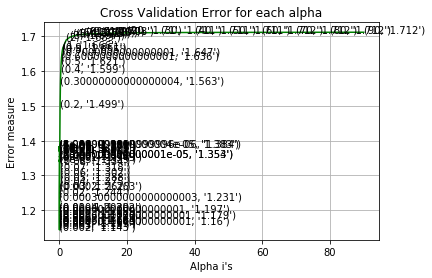

In [137]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [138]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.002 The train log loss is: 0.6183342567483479
For values of best alpha =  0.002 The cross validation log loss is: 1.1433127309847912
For values of best alpha =  0.002 The test log loss is: 1.110188171827144


Lets test our model with best hyper param

Log loss : 1.1433127309847912
Number of mis-classified points : 0.37593984962406013
-------------------- Confusion matrix --------------------


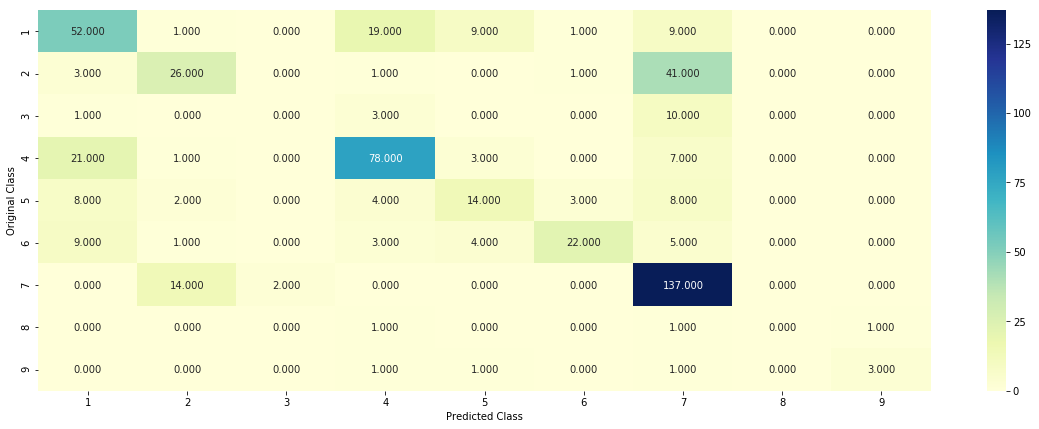

-------------------- Precision matrix (Columm Sum=1) --------------------


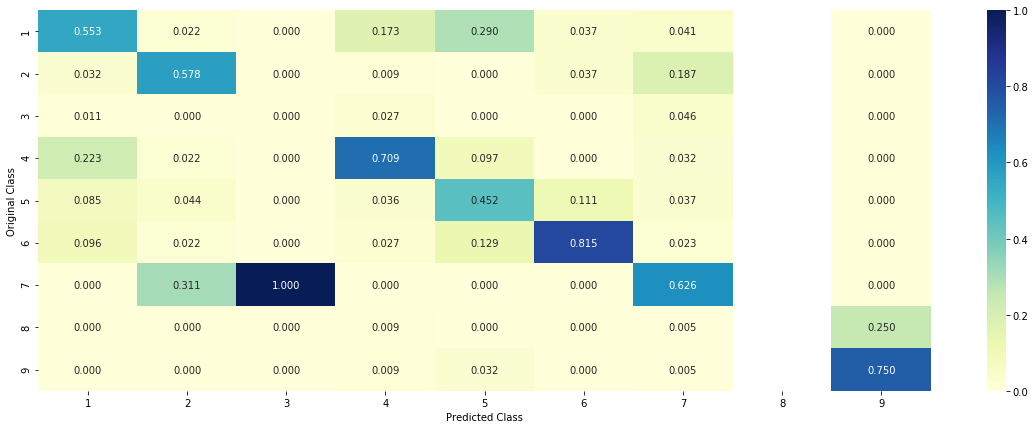

-------------------- Recall matrix (Row sum=1) --------------------


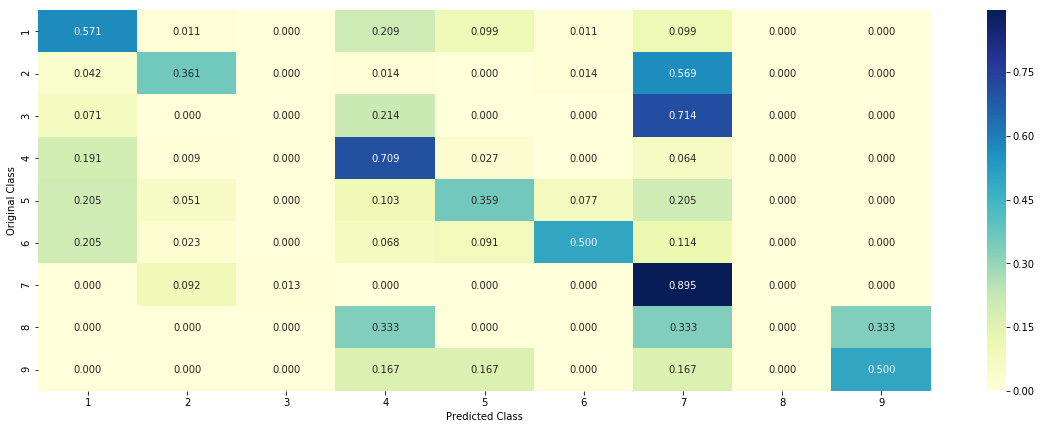

In [139]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

### Testing query point and interpretability

In [140]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.1183 0.3923 0.0245 0.1342 0.0719 0.0712 0.1732 0.0074 0.007 ]]
Actual Class : 2
--------------------------------------------------
78 Text feature [e255k] present in test data point [True]
121 Text feature [ccyr] present in test data point [True]
132 Text feature [t315i] present in test data point [True]
298 Text feature [ai] present in test data point [True]
329 Text feature [l387m] present in test data point [True]
494 Text feature [bosutinib] present in test data point [True]
Out of the top  500  features  6 are present in query point


## Linear Support Vector Machines

for C = 1e-05
Log Loss : 1.4045672701169023
for C = 2e-05
Log Loss : 1.3971424402189379
for C = 3.0000000000000004e-05
Log Loss : 1.4005696245092898
for C = 4e-05
Log Loss : 1.4070812025196564
for C = 5e-05
Log Loss : 1.3928844439253167
for C = 6.000000000000001e-05
Log Loss : 1.3795250927814953
for C = 7.000000000000001e-05
Log Loss : 1.4023551774970267
for C = 8e-05
Log Loss : 1.4017824508171601
for C = 9e-05
Log Loss : 1.3891888689752259
for C = 0.0001
Log Loss : 1.3706522438296602
for C = 0.0002
Log Loss : 1.3689284571632208
for C = 0.00030000000000000003
Log Loss : 1.358243738077303
for C = 0.0004
Log Loss : 1.3483770317266637
for C = 0.0005
Log Loss : 1.3329573625148166
for C = 0.0006000000000000001
Log Loss : 1.3187221933128723
for C = 0.0007
Log Loss : 1.305912250988394
for C = 0.0008
Log Loss : 1.302138084906501
for C = 0.0009000000000000001
Log Loss : 1.2973812038928865
for C = 0.001
Log Loss : 1.3020004876659415
for C = 0.002
Log Loss : 1.247440787458313
for C = 0.003
Log Lo

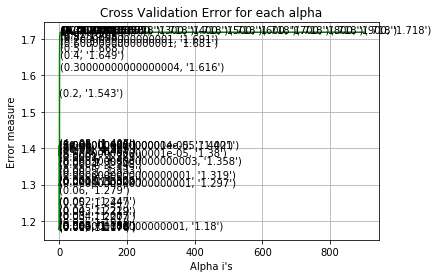

For values of best alpha =  0.006 The train log loss is: 0.722716083885361
For values of best alpha =  0.006 The cross validation log loss is: 1.1756969504345423
For values of best alpha =  0.006 The test log loss is: 1.1352308217250906


In [141]:
alpha = [(10 ** x)*y for x in range(-5, 3) for y in range(1, 10)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

### Testing model with best alpha values

Log loss : 1.1756969504345423
Number of mis-classified points : 0.37218045112781956
-------------------- Confusion matrix --------------------


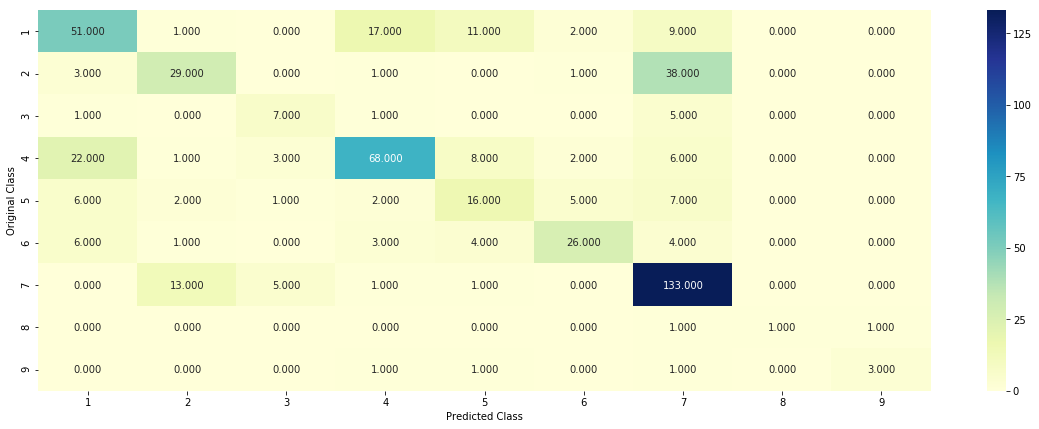

-------------------- Precision matrix (Columm Sum=1) --------------------


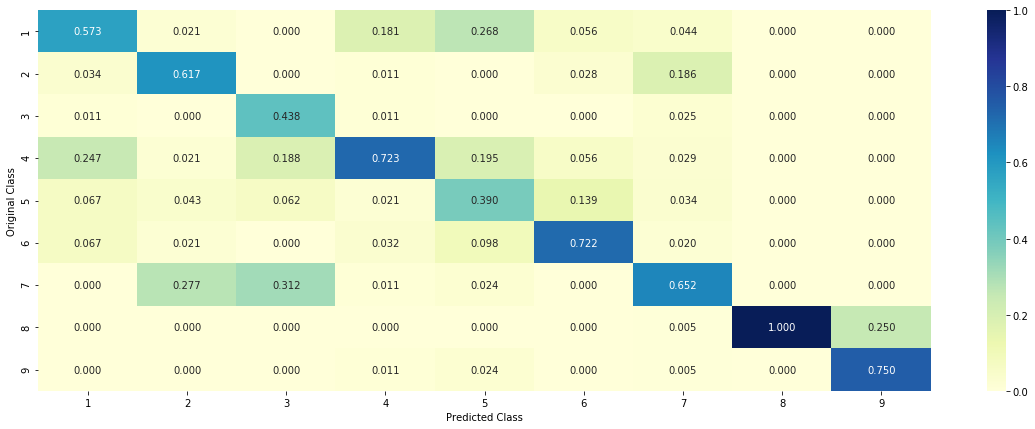

-------------------- Recall matrix (Row sum=1) --------------------


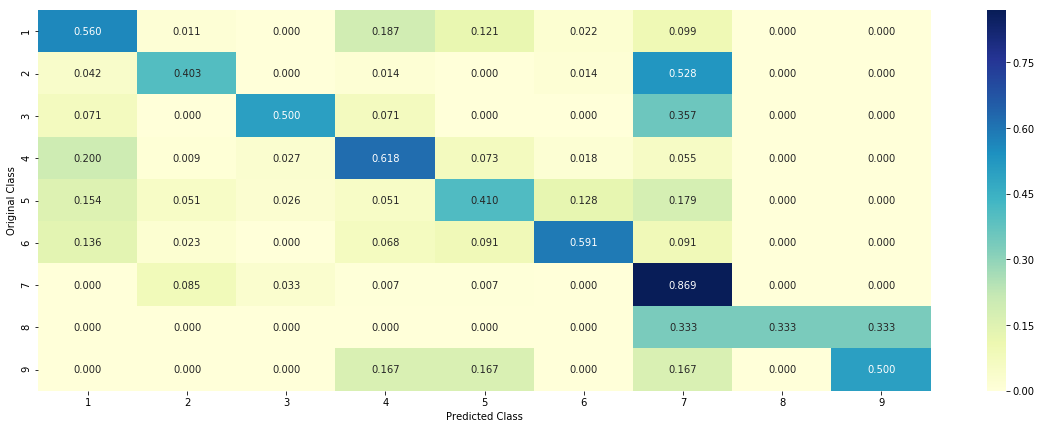

In [142]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

Querying some correctly classified point

In [143]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.1308 0.3512 0.0211 0.1522 0.0653 0.067  0.1996 0.0066 0.0061]]
Actual Class : 2
--------------------------------------------------
63 Text feature [e255k] present in test data point [True]
110 Text feature [ccyr] present in test data point [True]
136 Text feature [ai] present in test data point [True]
345 Text feature [bosutinib] present in test data point [True]
403 Text feature [t315i] present in test data point [True]
Out of the top  500  features  5 are present in query point


## Random Forest Classifier

### Model with One hot encoder

In [144]:
alpha = [(10*x) for x in range(1,200)]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


for n_estimators = 10 and max depth =  5
Log Loss : 1.3818723629541694
for n_estimators = 10 and max depth =  10
Log Loss : 1.3358501704452173
for n_estimators = 20 and max depth =  5
Log Loss : 1.340936233628208
for n_estimators = 20 and max depth =  10
Log Loss : 1.2718540307305233
for n_estimators = 30 and max depth =  5
Log Loss : 1.3144160489454073
for n_estimators = 30 and max depth =  10
Log Loss : 1.2412910565331254
for n_estimators = 40 and max depth =  5
Log Loss : 1.2841262195900331
for n_estimators = 40 and max depth =  10
Log Loss : 1.2258936570206937
for n_estimators = 50 and max depth =  5
Log Loss : 1.2748742690143413
for n_estimators = 50 and max depth =  10
Log Loss : 1.2180432133311763
for n_estimators = 60 and max depth =  5
Log Loss : 1.273165908011484
for n_estimators = 60 and max depth =  10
Log Loss : 1.209348342054616
for n_estimators = 70 and max depth =  5
Log Loss : 1.2732178532042677
for n_estimators = 70 and max depth =  10
Log Loss : 1.2080547433695927
fo

Log Loss : 1.220309892933285
for n_estimators = 580 and max depth =  10
Log Loss : 1.1754322337723546
for n_estimators = 590 and max depth =  5
Log Loss : 1.2197833349892855
for n_estimators = 590 and max depth =  10
Log Loss : 1.1750926520507907
for n_estimators = 600 and max depth =  5
Log Loss : 1.2197026744885278
for n_estimators = 600 and max depth =  10
Log Loss : 1.174987361423388
for n_estimators = 610 and max depth =  5
Log Loss : 1.2196776431912584
for n_estimators = 610 and max depth =  10
Log Loss : 1.1747219681691723
for n_estimators = 620 and max depth =  5
Log Loss : 1.2196903366605176
for n_estimators = 620 and max depth =  10
Log Loss : 1.1744199862735583
for n_estimators = 630 and max depth =  5
Log Loss : 1.2190927825519118
for n_estimators = 630 and max depth =  10
Log Loss : 1.1742345893254218
for n_estimators = 640 and max depth =  5
Log Loss : 1.218667103033891
for n_estimators = 640 and max depth =  10
Log Loss : 1.1745292517354249
for n_estimators = 650 and max

Log Loss : 1.2163460227725988
for n_estimators = 1150 and max depth =  10
Log Loss : 1.1706402129568239
for n_estimators = 1160 and max depth =  5
Log Loss : 1.2164424624761592
for n_estimators = 1160 and max depth =  10
Log Loss : 1.1706174739358288
for n_estimators = 1170 and max depth =  5
Log Loss : 1.2167423924801917
for n_estimators = 1170 and max depth =  10
Log Loss : 1.1706731876472347
for n_estimators = 1180 and max depth =  5
Log Loss : 1.2169020300695452
for n_estimators = 1180 and max depth =  10
Log Loss : 1.1710508727291387
for n_estimators = 1190 and max depth =  5
Log Loss : 1.216891460890663
for n_estimators = 1190 and max depth =  10
Log Loss : 1.171129786991849
for n_estimators = 1200 and max depth =  5
Log Loss : 1.2165671617342293
for n_estimators = 1200 and max depth =  10
Log Loss : 1.1708976038756866
for n_estimators = 1210 and max depth =  5
Log Loss : 1.2170281147222488
for n_estimators = 1210 and max depth =  10
Log Loss : 1.1708490447817652
for n_estimators

Log Loss : 1.2161625122403013
for n_estimators = 1710 and max depth =  10
Log Loss : 1.172709418232516
for n_estimators = 1720 and max depth =  5
Log Loss : 1.2161588177661269
for n_estimators = 1720 and max depth =  10
Log Loss : 1.172868714692552
for n_estimators = 1730 and max depth =  5
Log Loss : 1.216174509461994
for n_estimators = 1730 and max depth =  10
Log Loss : 1.172794665954423
for n_estimators = 1740 and max depth =  5
Log Loss : 1.2162710963978247
for n_estimators = 1740 and max depth =  10
Log Loss : 1.172734076297785
for n_estimators = 1750 and max depth =  5
Log Loss : 1.2160840877932915
for n_estimators = 1750 and max depth =  10
Log Loss : 1.1725642538854089
for n_estimators = 1760 and max depth =  5
Log Loss : 1.2157337829799018
for n_estimators = 1760 and max depth =  10
Log Loss : 1.1724798163916192
for n_estimators = 1770 and max depth =  5
Log Loss : 1.2159132141512936
for n_estimators = 1770 and max depth =  10
Log Loss : 1.1725105904378819
for n_estimators = 

In [146]:
gc.collect()

384

In [148]:
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best estimator =  1120 The train log loss is: 0.6934386289337197
For values of best estimator =  1120 The cross validation log loss is: 1.1702077345918613
For values of best estimator =  1120 The test log loss is: 1.1336679401363756


Lets test it on testing data using best hyper param

Log loss : 1.1702077345918598
Number of mis-classified points : 0.36466165413533835
-------------------- Confusion matrix --------------------


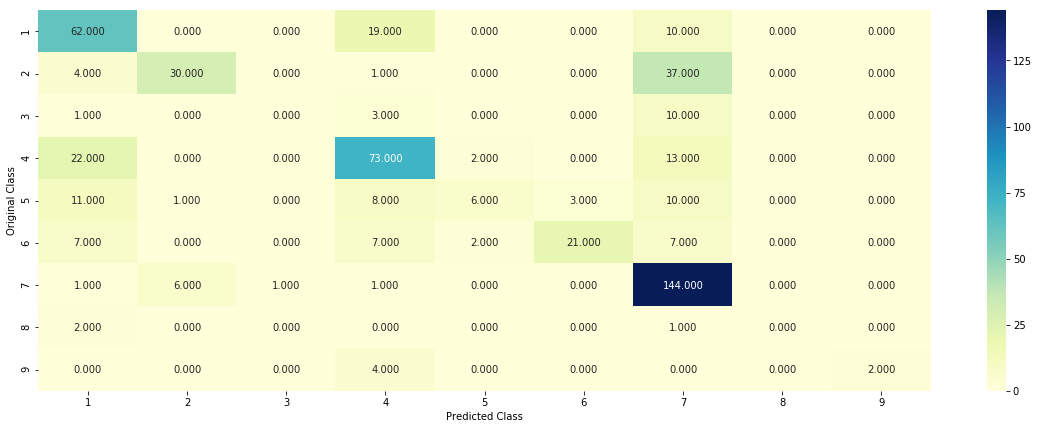

-------------------- Precision matrix (Columm Sum=1) --------------------


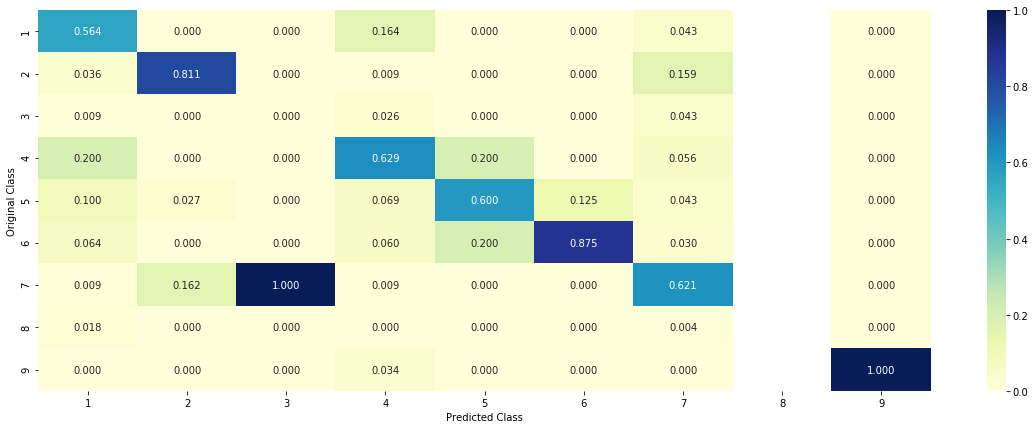

-------------------- Recall matrix (Row sum=1) --------------------


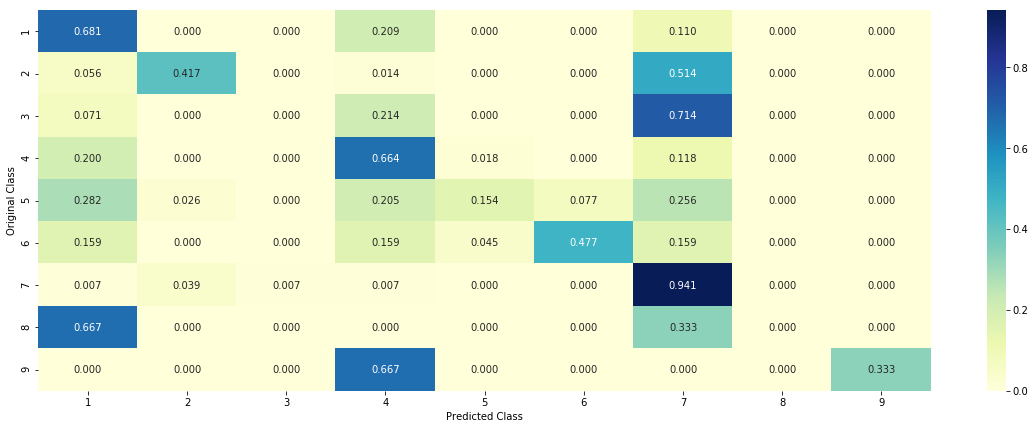

In [149]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

In [150]:
# test_point_index = 10
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.0878 0.5018 0.0203 0.0946 0.049  0.0455 0.1896 0.0064 0.0051]]
Actual Class : 2
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
3 Text feature [tyrosine] present in test data point [True]
4 Text feature [constitutive] present in test data point [True]
5 Text feature [activation] present in test data point [True]
10 Text feature [treatment] present in test data point [True]
12 Text feature [function] present in test data point [True]
14 Text feature [signaling] present in test data point [True]
15 Text feature [constitutively] present in test data point [True]
17 Text feature [downstream] present in test data point [True]
23 Text feature [therapy] present in test data point [True]
25 Text feature [months] present in test data point [True]
28 Text feature [inhibitor] present in test data point [True]
31 Text feature [functional] present in test data point [True]
32 Text fea

In [153]:
gc.collect()

32

### RF with Response Coding

In [155]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 2.1601581304716095
for n_estimators = 10 and max depth =  3
Log Loss : 1.819917251575367
for n_estimators = 10 and max depth =  5
Log Loss : 1.7060180101447346
for n_estimators = 10 and max depth =  10
Log Loss : 1.7231841543928477
for n_estimators = 50 and max depth =  2
Log Loss : 1.7964686309080702
for n_estimators = 50 and max depth =  3
Log Loss : 1.500195994423705
for n_estimators = 50 and max depth =  5
Log Loss : 1.6426118865118293
for n_estimators = 50 and max depth =  10
Log Loss : 1.7703287138856667
for n_estimators = 100 and max depth =  2
Log Loss : 1.6309997454966538
for n_estimators = 100 and max depth =  3
Log Loss : 1.5200231791968952
for n_estimators = 100 and max depth =  5
Log Loss : 1.3620768441537168
for n_estimators = 100 and max depth =  10
Log Loss : 1.7802894654428727
for n_estimators = 200 and max depth =  2
Log Loss : 1.7151773988894699
for n_estimators = 200 and max depth =  3
Log Loss : 1.5427049815419955

Testing model with best hyper param

Log loss : 1.3620768441537165
Number of mis-classified points : 0.4774436090225564
-------------------- Confusion matrix --------------------


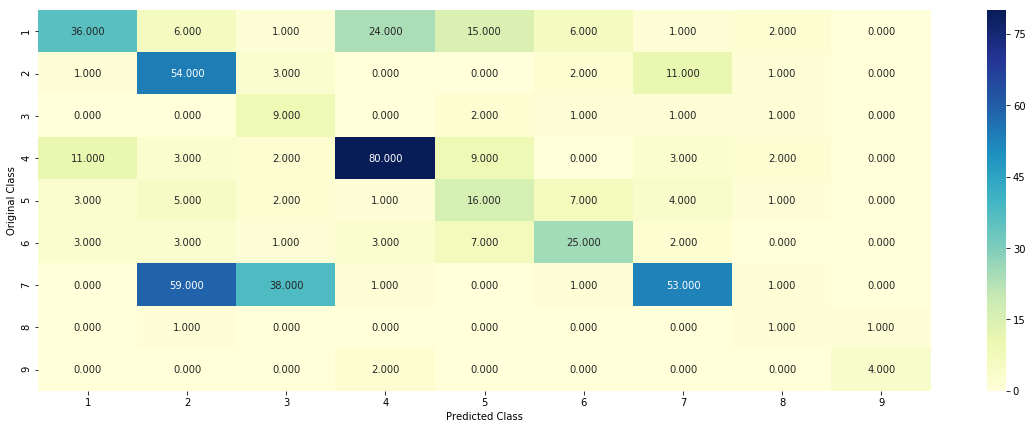

-------------------- Precision matrix (Columm Sum=1) --------------------


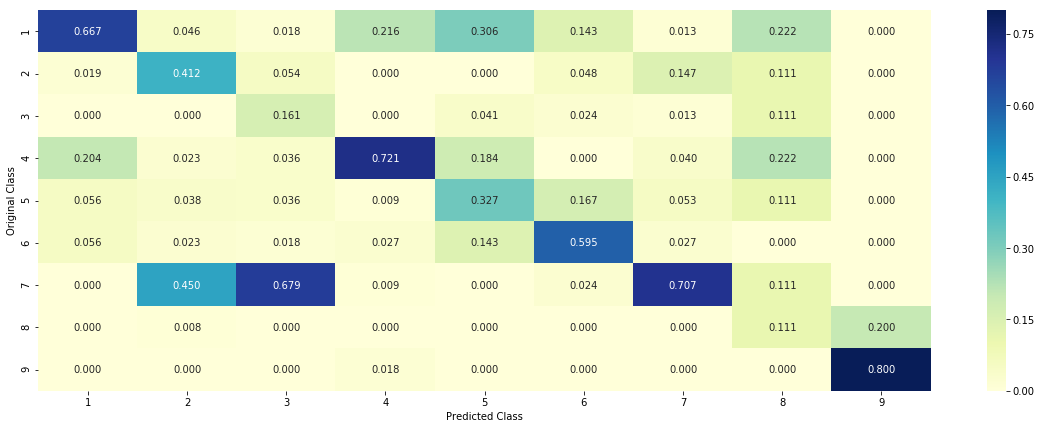

-------------------- Recall matrix (Row sum=1) --------------------


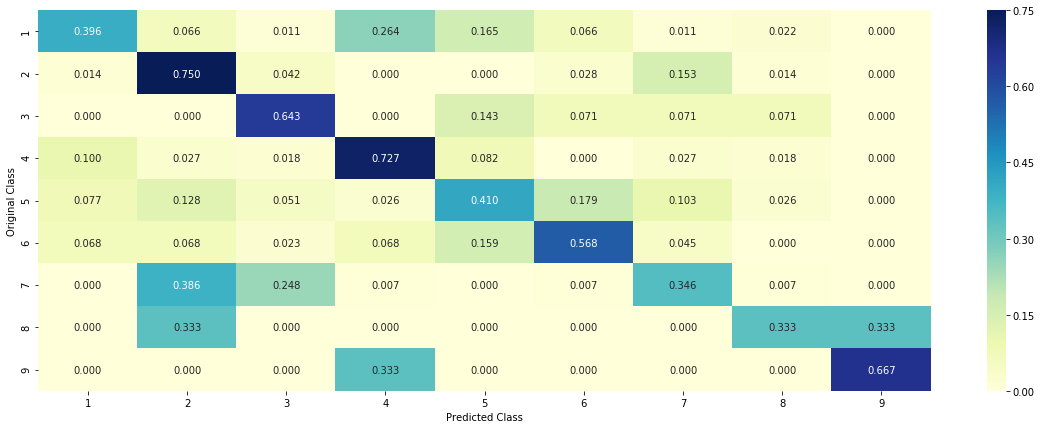

In [156]:
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

Query the classified point

In [157]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 2
Predicted Class Probabilities: [[0.0126 0.7593 0.0817 0.0318 0.0116 0.021  0.0408 0.0237 0.0175]]
Actual Class : 2
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Text is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Text is important feature
Variation is important feature
Text is important feature
Gene is important feature
Text is important feature
Gene is important feature
Gene is important feature


## Stacking model

In [158]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.13
Support vector machines : Log Loss: 1.71
Naive Bayes : Log Loss: 1.32
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.179
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.042
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.545
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.176
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.248
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.456


Testing with best hyper param

Log loss (train) on the stacking classifier : 0.6652219432103006
Log loss (CV) on the stacking classifier : 1.1764539846878932
Log loss (test) on the stacking classifier : 1.156874404234389
Number of missclassified point : 0.37142857142857144
-------------------- Confusion matrix --------------------


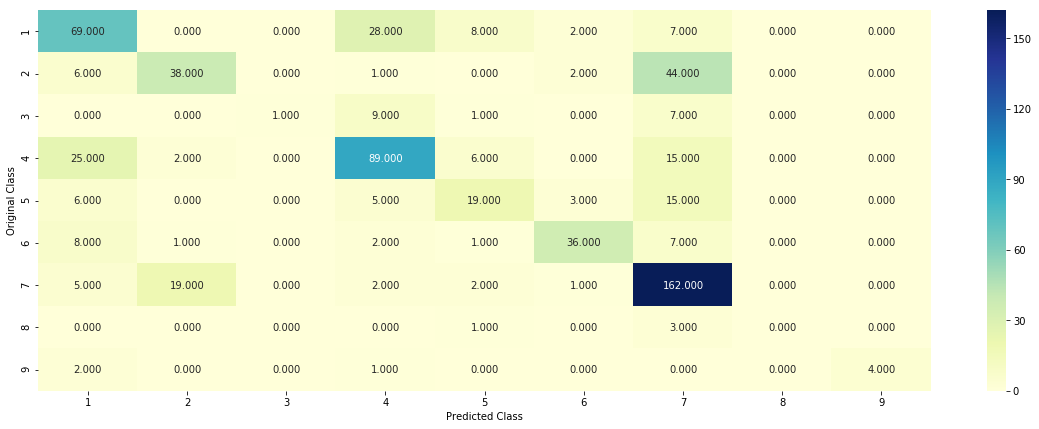

-------------------- Precision matrix (Columm Sum=1) --------------------


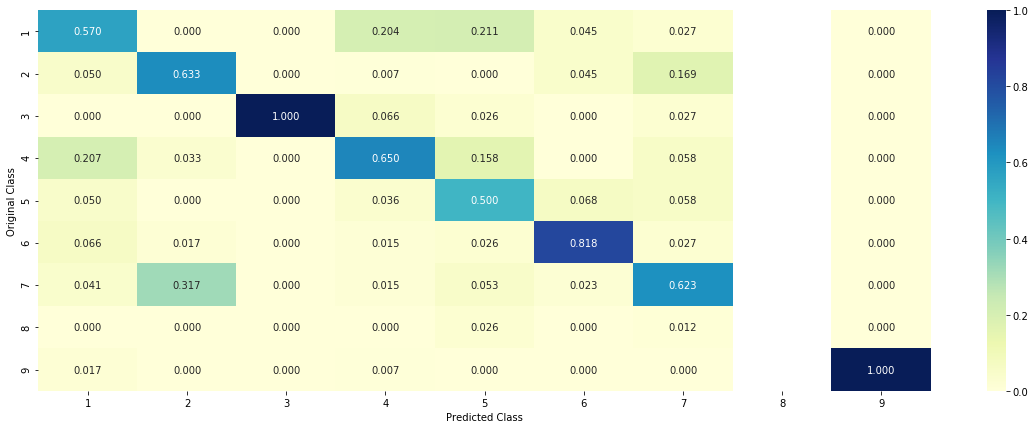

-------------------- Recall matrix (Row sum=1) --------------------


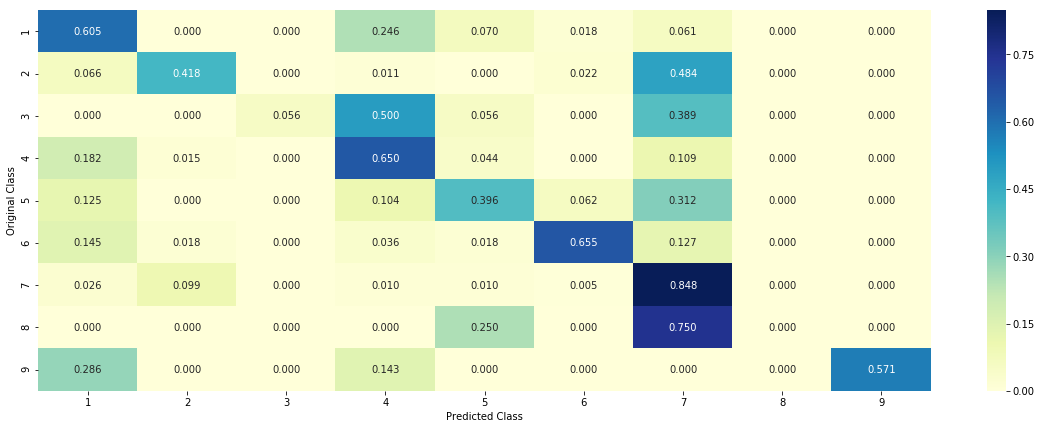

In [159]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

## Maximum voting Classifier

Log loss (train) on the VotingClassifier : 0.9105118711201182
Log loss (CV) on the VotingClassifier : 1.2371384085495047
Log loss (test) on the VotingClassifier : 1.2074734321201583
Number of missclassified point : 0.3609022556390977
-------------------- Confusion matrix --------------------


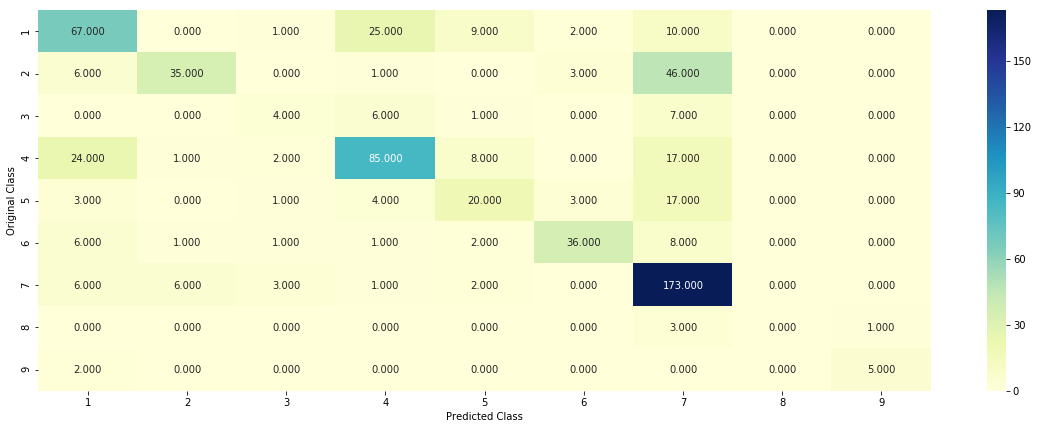

-------------------- Precision matrix (Columm Sum=1) --------------------


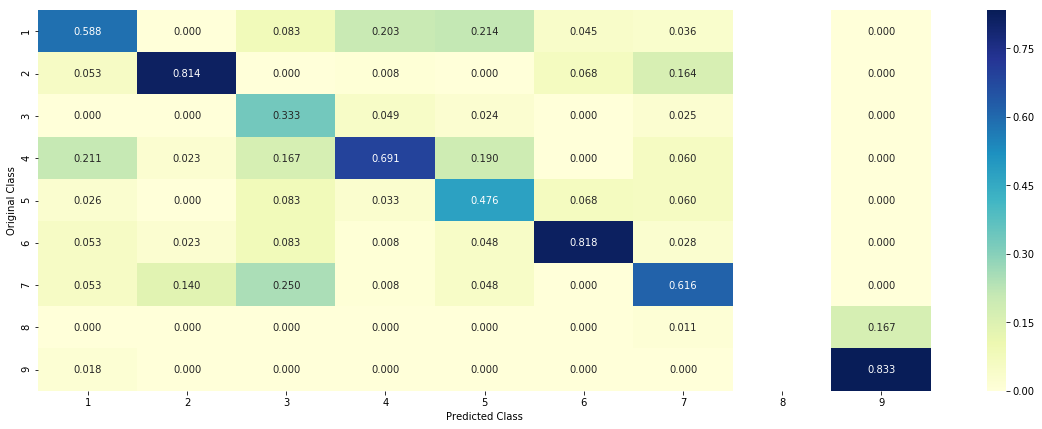

-------------------- Recall matrix (Row sum=1) --------------------


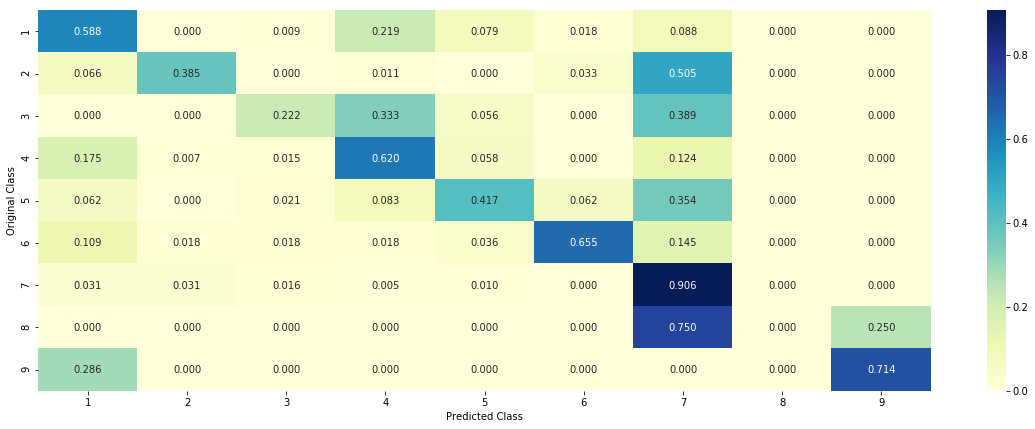

In [160]:
#Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))